## Geneformer Embeddings

### Imports

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from env.imports import *

In [42]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [43]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 53.5%
RAM Usage: 16.3%
Available RAM: 842.6G
Total RAM: 1007.0G
52.4G


In [44]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 0.03 GB


### Setup

In [45]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

In [57]:
X_UKBB_srs, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='raw_mirror_interpolate', return_valid_genes=True)
X_UKBB_raw, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='mirror_interpolate', return_valid_genes=True)


In [58]:
import numpy as np

are_identical = np.allclose(X_UKBB_srs, X_UKBB_raw)
print("Matrices identical:", are_identical)

difference = np.abs(X_UKBB_srs - X_UKBB_raw)
print("Max absolute difference:", np.max(difference))

Matrices identical: False
Max absolute difference: nan


In [60]:
# Sort values within each row by rank
sorted_srs = np.take_along_axis(X_UKBB_srs, np.argsort(X_UKBB_srs, axis=1), axis=1)
sorted_raw = np.take_along_axis(X_UKBB_raw, np.argsort(X_UKBB_raw, axis=1), axis=1)

# Compare sorted rows to get boolean vector
rows_identical = np.all(np.isclose(sorted_srs, sorted_raw), axis=1)

print("Number of identical rows:", np.sum(rows_identical))
print("Number of different rows:", len(rows_identical) - np.sum(rows_identical))

# Show indices of mismatched rows
if not np.all(rows_identical):
    mismatched_indices = np.where(~rows_identical)[0]
    print("Indices of mismatched rows:", mismatched_indices[:10])  # First 10 mismatches

Number of identical rows: 0
Number of different rows: 456
Indices of mismatched rows: [0 1 2 3 4 5 6 7 8 9]


In [46]:
# Load data
print("Loading data...")
X_UKBB, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='raw_mirror_interpolate', return_valid_genes=True)
Y_UKBB = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords_UKBB = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_UKBB = ~np.isnan(X_UKBB).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_UKBB = np.where(valid_indices_UKBB)[0]
valid2true_mapping_UKBB = dict(enumerate(valid_indices_values_UKBB))

# Subset all data using valid indices
X_UKBB_valid = X_UKBB[valid_indices_UKBB]
Y_UKBB_valid = Y_UKBB[valid_indices_UKBB][:, valid_indices_UKBB]
coords_UKBB_valid = coords_UKBB[valid_indices_UKBB]
labels_UKBB = [labels_UKBB[i] for i in range(len(labels_UKBB)) if valid_indices_UKBB[i]]
network_labels_UKBB = network_labels_UKBB[valid_indices_UKBB]

print(f"X_UKBB_valid shape: {X_UKBB_valid.shape}")

# Create dataset from X_UKBB_valid that contains each ROI as a sample
X = torch.tensor(X_UKBB_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_UKBB_valid.shape[0], shuffle=False)

print(X.shape)
print(X.dtype)

# # Create full region pair dataset (not used here)
# print("Creating RegionPairDataset...")
# dataset_UKBB = RegionPairDataset(
#     X=X_UKBB_valid,
#     Y=Y_UKBB_valid,
#     coords=coords_UKBB_valid,
#     valid2true_mapping=valid2true_mapping_UKBB,
#     dataset='UKBB',
#     parcellation='S456'
# )

# batch_size = 1024

# # Create dataloader with all pairs
# dataloader_UKBB = DataLoader(
#     dataset_UKBB,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=4,
#     pin_memory=True  # Speed up data transfer to GPU
# )

Loading data...
X_UKBB_valid shape: (455, 15633)
torch.Size([455, 15633])
torch.float32


Map genes from AHBA to Ensembl

In [47]:
# Create mapping from gene symbols to Ensembl IDs using example table from Geneformer, https://huggingface.co/api/resolve-cache/datasets/ctheodoris/Genecorpus-30M/71fae97a141652584e0cf09e8ace306e9b9e6d8c/example_input_files%2Fgene_info_table.csv?%2Fdatasets%2Fctheodoris%2FGenecorpus-30M%2Fresolve%2Fmain%2Fexample_input_files%2Fgene_info_table.csv=&etag=%2203d65efa77c6550c99889007f246294fc660000e%22
gene_info_df = pd.read_csv('example_input_files_gene_info_table.txt')
symbol_to_ensembl = dict(zip(gene_info_df['gene_name'], gene_info_df['ensembl_id']))

# Convert gene symbols to Ensembl IDs where possible
ensembl_ids = []
unmapped_symbols = []

for symbol in valid_genes:
    if symbol in symbol_to_ensembl:
        ensembl_ids.append(symbol_to_ensembl[symbol])
    else:
        unmapped_symbols.append(symbol)
        ensembl_ids.append(None)

print(f"Successfully mapped {len(ensembl_ids) - len(unmapped_symbols)} genes to Ensembl IDs")
print(f"Could not map {len(unmapped_symbols)} genes")
print("\nFirst 10 mappings:")
for i in range(min(10, len(valid_genes))):
    print(f"{valid_genes[i]} -> {ensembl_ids[i]}")

print("ensembl ID format: ", ensembl_ids[:10])

Successfully mapped 15035 genes to Ensembl IDs
Could not map 598 genes

First 10 mappings:
A1BG -> ENSG00000121410
A1BG-AS1 -> ENSG00000268895
A2M -> ENSG00000175899
A2ML1 -> ENSG00000166535
A3GALT2 -> ENSG00000184389
A4GALT -> ENSG00000128274
AAAS -> ENSG00000094914
AACS -> ENSG00000081760
AADACL3 -> ENSG00000188984
AADAT -> ENSG00000109576
ensembl ID format:  ['ENSG00000121410', 'ENSG00000268895', 'ENSG00000175899', 'ENSG00000166535', 'ENSG00000184389', 'ENSG00000128274', 'ENSG00000094914', 'ENSG00000081760', 'ENSG00000188984', 'ENSG00000109576']


Setup AnnData file for tokenization

In [49]:
X_np = X.cpu().numpy()

# ensembl_IDs is a list of length 15633
valid_gene_mask = [eid is not None for eid in ensembl_ids]
valid_ensembl_ids = [eid for eid in ensembl_ids if eid is not None]

# Filter the matrix to remove genes without Ensembl IDs
X_filtered = X_np[:, valid_gene_mask]

# Create a DataFrame for easy row/column labeling
df = pd.DataFrame(X_filtered, columns=valid_ensembl_ids)

# Compute counts from all genes, not just the filtered ones
n_counts = X_np.sum(axis=1) 
# n_counts = X_filtered.sum(axis=1)  # shape (455,)

# Create AnnData object
adata = AnnData(X_filtered)

# Assign Ensembl IDs to variables
adata.var_names = valid_ensembl_ids

# Patch the var dataframe
adata.var["ensembl_id"] = adata.var.index

# Assign cell/sample IDs
adata.obs_names = [f"sample_{i}" for i in range(X_np.shape[0])]

# Add total pseudocounts to .obs
adata.obs["n_counts"] = n_counts

# adata.obs["cell_type"] = "bulk" # not sure if this is valid here
adata.obs["organ_major"] = "brain"

adata.write_h5ad("./data/geneformer/ahba_pseudocounts.h5ad")

Evaluate anndata object

In [50]:
import anndata

# Load your AnnData object
adata = anndata.read_h5ad("/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad")

# --- Basic structure ---
print("🧬 Shape of X (cells x genes):", adata.shape)
print("📋 Type of X:", type(adata.X))

# --- obs: Metadata for observations (cells) ---
print("\n🔎 `adata.obs` (cell-level metadata):")
display(adata.obs.head())
print("📊 Columns in `obs`:", list(adata.obs.columns))

# --- var: Metadata for variables (genes) ---
print("\n🧬 `adata.var` (gene-level metadata):")
display(adata.var.head())
print("🧬 Columns in `var`:", list(adata.var.columns))

# --- layers (optional) ---
print("\n🧱 Layers (if any):", list(adata.layers.keys()) if adata.layers else "None")

# --- uns: Unstructured data (e.g., UMAP settings, config) ---
print("\n📦 `adata.uns` keys:", list(adata.uns.keys()))

# --- obsm / varm: Multi-dimensional annotations (e.g., PCA/UMAP coordinates) ---
print("📐 `adata.obsm` keys (e.g., UMAP):", list(adata.obsm.keys()))
print("📐 `adata.varm` keys:", list(adata.varm.keys()))

# --- Check for specific common elements ---
if "ensembl_id" in adata.var.columns:
    print("\n✅ 'ensembl_id' found in `adata.var`.")
else:
    print("\n⚠️ 'ensembl_id' missing from `adata.var`.")

if "n_counts" in adata.obs.columns:
    print("✅ 'n_counts' found in `adata.obs`.")
else:
    print("⚠️ 'n_counts' missing from `adata.obs`.")

🧬 Shape of X (cells x genes): (455, 15035)
📋 Type of X: <class 'numpy.ndarray'>

🔎 `adata.obs` (cell-level metadata):


,n_counts,organ_major
sample_0,111284.562500,brain
sample_1,110295.015625,brain
sample_2,110910.445312,brain
sample_3,111360.992188,brain
sample_4,110722.000000,brain


📊 Columns in `obs`: ['n_counts', 'organ_major']

🧬 `adata.var` (gene-level metadata):


,ensembl_id
ENSG00000121410,ENSG00000121410
ENSG00000268895,ENSG00000268895
ENSG00000175899,ENSG00000175899
ENSG00000166535,ENSG00000166535
ENSG00000184389,ENSG00000184389


🧬 Columns in `var`: ['ensembl_id']

🧱 Layers (if any): None

📦 `adata.uns` keys: []
📐 `adata.obsm` keys (e.g., UMAP): []
📐 `adata.varm` keys: []

✅ 'ensembl_id' found in `adata.var`.
✅ 'n_counts' found in `adata.obs`.


In [51]:
from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor

In [52]:
tokenizer = TranscriptomeTokenizer(
    custom_attr_name_dict={"organ_major": "organ_major"},  # ✅ must match name in `.obs`
    nproc=16,
    model_version="V2",
    gene_median_file="/scratch/asr655/main_env/Geneformer/geneformer/gene_median_dictionary_gc104M.pkl",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl",
    gene_mapping_file="/scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl"
)

tokenizer.tokenize_data(
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer",
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer",
    "ahba_tokenized",
    file_format="h5ad"
)

Tokenizing /scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad
/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [54]:

embex = EmbExtractor(
    model_type="Pretrained",
    num_classes=0,
    emb_mode="cell",
    cell_emb_style="mean_pool",
    emb_layer=-1,
    emb_label=["organ_major"],
    labels_to_plot=["organ_major"],
    max_ncells=None,
    forward_batch_size=128,
    nproc=16,
    model_version="V2",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
)

model_path = "/scratch/asr655/main_env/Geneformer/Geneformer-V2-104M"
tokenized_data_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_tokenized.dataset"
output_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/embeddings"
output_prefix = "ahba_emb_with_organ"

embs = embex.extract_embs(
    model_directory=model_path,
    input_data_file=tokenized_data_path,
    output_directory=output_dir,
    output_prefix=output_prefix, 
    output_torch_embs=False
)

  self.comm = Comm(**args)



  0%|          | 0/4 [00:00<?, ?it/s]

In [55]:
embs

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,organ_major
0,0.676737,0.529420,-0.455771,-0.386355,-0.663005,-0.357830,-0.834294,0.348112,0.176481,-0.940223,...,0.085674,0.362624,-0.488588,-0.435740,0.237410,-0.332831,0.242679,-0.655089,0.154928,brain
1,0.589000,0.419860,-0.486359,-0.428769,-0.772145,-0.415654,-0.847002,0.366449,0.165296,-0.934581,...,0.126854,0.355971,-0.497852,-0.441349,0.233678,-0.374515,0.271119,-0.733981,0.189032,brain
2,0.673770,0.523607,-0.510677,-0.370922,-0.575804,-0.373228,-0.830606,0.343800,0.291142,-0.967051,...,0.065667,0.368260,-0.381209,-0.411313,0.232415,-0.366041,0.285602,-0.758497,0.255126,brain
3,0.573692,0.461867,-0.545779,-0.439943,-0.561285,-0.403296,-0.874225,0.325397,0.250098,-0.883365,...,0.113701,0.301087,-0.417939,-0.492865,0.214463,-0.315760,0.209976,-0.680593,0.229490,brain
4,0.637581,0.501383,-0.552350,-0.330728,-0.564553,-0.363673,-0.890156,0.475084,0.228648,-0.956805,...,0.086470,0.342128,-0.438086,-0.393847,0.319784,-0.427769,0.266595,-0.668754,0.299239,brain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.711348,0.474159,-0.513454,-0.451357,-0.584713,-0.413004,-0.864239,0.403508,0.278886,-0.915201,...,0.162591,0.214126,-0.420266,-0.447322,0.216084,-0.419264,0.317689,-0.692631,0.252181,brain
451,0.703501,0.470702,-0.548025,-0.454243,-0.604781,-0.338332,-0.830032,0.381851,0.285528,-0.996880,...,0.091221,0.379733,-0.545184,-0.417539,0.309148,-0.259889,0.287209,-0.791006,0.185951,brain
452,0.653836,0.453447,-0.402705,-0.499467,-0.627678,-0.279139,-0.812445,0.389479,0.329424,-0.907944,...,0.037144,0.341717,-0.451335,-0.496538,0.287459,-0.310080,0.149366,-0.749031,0.145062,brain
453,0.612402,0.429016,-0.522772,-0.419514,-0.625507,-0.392121,-0.783789,0.305561,0.288459,-0.901939,...,0.118346,0.328101,-0.511763,-0.487503,0.373856,-0.400435,0.164846,-0.702556,0.207225,brain


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



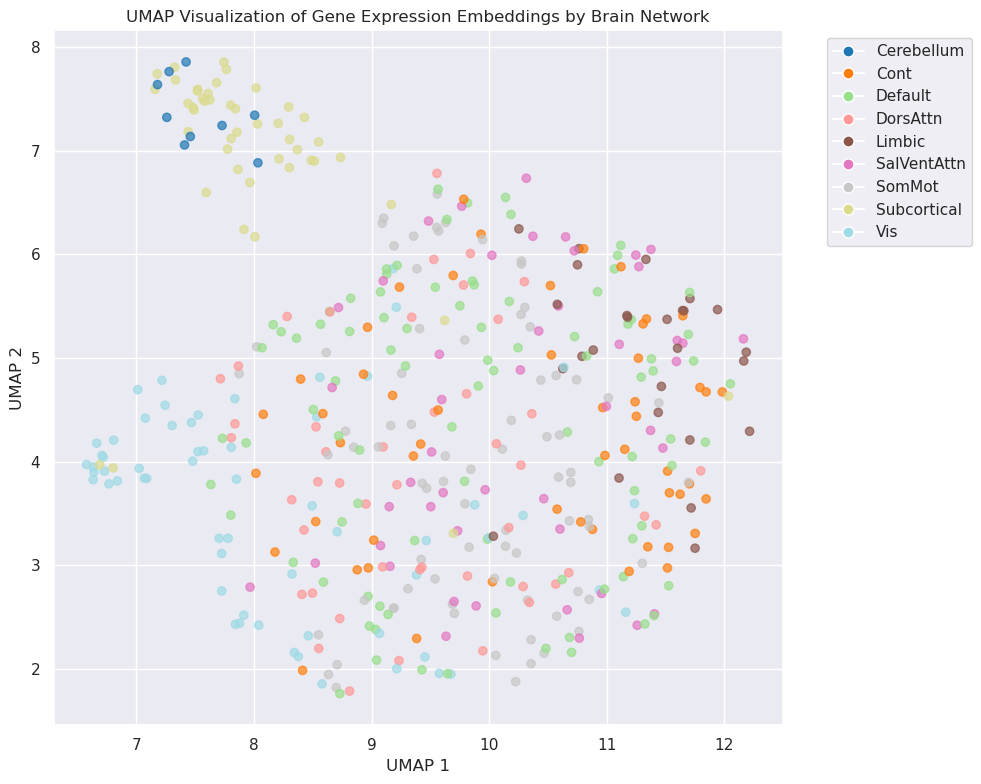

In [56]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Create UMAP reducer
reducer = umap.UMAP(random_state=42)

# Fit and transform the embeddings (excluding the organ_major column)
embedding_cols = embs.select_dtypes(include=['float64', 'float32']).columns
umap_embeddings = reducer.fit_transform(embs[embedding_cols])

# Define colors for each network
unique_networks = np.unique(network_labels_UKBB)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_networks)))
color_dict = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = [color_dict[label] for label in network_labels_UKBB]

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                     c=point_colors, alpha=0.7)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=color_dict[label], label=label, markersize=8)
                  for label in unique_networks]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP Visualization of Gene Expression Embeddings by Brain Network')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()